In [57]:
from copy import deepcopy
import numpy as np
import random
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, transpile, assemble
from qiskit.providers import backend
from qiskit.aqua.components.optimizers import COBYLA
import matplotlib.pyplot as plt
import itertools

In [58]:
# TYPES:
CAT = "c"
# DOG = "d"
MOUSE = "m"
EMPTY = "emp"

# ACTIONS:
UP = "00"
DOWN = "01"
LEFT = "10"
RIGHT = "11"
ACTIONS = [UP, DOWN, LEFT, RIGHT]

# random seed
random.seed(10)
np.random.seed(10)

In [59]:
# state of cat
class State:
    def __init__(self, catP):
        #self.row = catP[0]
        #self.column = catP[1]
        self.catP = catP

    def __eq__(self, other):
        return isinstance(other, State) and self.catP == other.catP

    def __hash__(self):
        return hash(str(self.catP))

    def __str__(self):
        return f"State(cat_pos={self.catP})"

In [60]:
# GridWorld
# e.g.
#  MOUSE | EMPTY | EMPTY
#  EMPTY | EMPTY | EMPTY
#  EMPTY | EMPTY | CAT
class GridWorld:
    def __init__(self, s, catP, mouseP):
        self.numRows = s[0]
        self.numColumns = s[1]
        self.catP = catP
        self.mouseP = mouseP
        # self.dogP = dogP
        assert(not self.compaireList(self.catP, self.mouseP))
    
    def getItem(self, p):
        if p[0]>=self.numRows or p[0]<0:
            return None
        if p[1]>=self.numColumns or p[1]<0:
            return None
        if self.compaireList(p, catP):
            return CAT
        elif self.compaireList(p, mouseP):
            return MOUSE
        # elif self.compaireList(p, DOG):
        #     return DOG
        else:
            return EMPTY

    def compaireList(self, l1,l2):
        for i, j in zip(l1, l2):
            if i!=j:
                return False
        return True

    def getNumRows(self):
        return self.numRows

    def getNumColumns(self):
        return self.numColumns

    def getMouse(self):
        return self.mouse
    
    def getCatP(self):
        return self.catP

    def setCatP(self, p):
        self.catP = p
        
    def setMouseP(self, p):
        self.mouseP = p
    
    def initCatState(self, rd = False):
        # init cat position
        if not rd:
            catP = [self.getNumRows() - 1, self.getNumColumns() - 1]
        else:
            catP = [random.randint(0, self.getNumRows()), random.randint(0, self.getNumColumns())]
            while self.getItem(catP) != EMPTY and self.getItem(catP) != CAT:
                catP = [random.randint(0, self.getNumRows()), random.randint(0, self.getNumColumns())]
        self.setCatP(catP)
        return State(catP)
    
    def show(self):
        output = ""
        for i in range(self.numRows):
            for j in range(self.numColumns):
                if self.compaireList([i,j], self.catP):
                    output += CAT + " "
                if self.compaireList([i,j], self.mouseP):
                    output += MOUSE + " "
                if not self.compaireList([i,j], self.catP) and not self.compaireList([i,j], self.mouseP):
                    output += EMPTY + " "
            output += "\n"
        print(output)

In [61]:
# QNet
class QNet:
    
    def __init__(self, qTable, gridWorld:GridWorld, alpha=0.1, gamma=1.0, eps=0.2, actions=[UP, DOWN, LEFT, RIGHT], numParams=6):
        self.gw = gridWorld
        self.qt = qTable
        self.eps = eps
        self.backend = Aer.get_backend("qasm_simulator")
        self.NUM_SHOTS = 1000 # number of measurements 
        self.optimizer = COBYLA(maxiter=500, tol=0.0001) # off the shelf
        self.gamma = gamma
        self.alpha = alpha
        self.ACTIONS = actions

        # self.rets = {(0,0):([0,..,0],0.0,0), ...}
        self.rets = dict() # resulting parameters after optimization for all points in the grid

        self.state = None
        
        for i in range(self.gw.getNumRows()):
            for j in range(self.gw.getNumColumns()):
                self.rets[i, j] = (np.random.rand(numParams), 0.0, 0) 
    
    def qcMaker(self, params):
        qr = QuantumRegister(2, name="q")
        cr = ClassicalRegister(2, name="c")
        qc = QuantumCircuit(qr, cr)
        qc.u3(params[0], params[1], params[2], qr[0])
        qc.u3(params[3], params[4], params[5], qr[1])
        # qc.cx(qr[0], qr[1])
        qc.measure(qr, cr)
        return qc

    def newPosition(self, state, action):
        p = deepcopy(state.catP)
        if action == UP:
            p[0] = max(0, p[0] - 1)
        elif action == DOWN:
            p[0] = min(self.gw.getNumRows() - 1, p[0]+1)
        elif action == LEFT:
            p[1] = max(0, p[1] - 1)
        elif action == RIGHT:
            p[1] = min(self.gw.getNumColumns() - 1, p[1] + 1)
        else:
            raise ValueError(f"Unkown action {action}")
        return p
        
    def getReward(self, p):
        grid = self.gw.getItem(p)
        if grid == EMPTY:
            reward = -1
        # elif grid == DOG:
        #     reward = -1000
        elif grid == MOUSE:
            reward = 1000
        elif grid == CAT:
            reward = -1 # (maybe less than reward of empty)
        else:
            raise ValueError(f"Unknown grid item {grid}")
        return reward
    
    def selectAction(self, state, training):
        if random.uniform(0, 1) < self.eps:
            return random.choice(self.ACTIONS)
        else:
            if training:
                self.state = deepcopy(state)
                self.updateCircuit(state)
            return self.ACTIONS[np.argmax(self.qt[self.state.catP[0], self.state.catP[1]])]
        
    def lossFunction(self, params):
        action = ""
        qc = self.qcMaker(params=params)
        t_qc = transpile(qc, self.backend)
        job = assemble(t_qc, shots=self.NUM_SHOTS)
        rlt = self.backend.run(job).result()
        counts = rlt.get_counts(qc)
        # speedup training, cross the ravine
        if random.uniform(0, 1) < self.eps:
            action = random.choice(self.ACTIONS)
        else:
            action = max(counts, key = counts.get)
        
        nextPosition = self.newPosition(self.state, action) # handle the 
        reward = self.getReward(nextPosition)
        # update q-table(but not very sure, update only for this action or for all actions)
        targetQvalue = reward + self.gamma *  np.max(self.qt[nextPosition[0],nextPosition[1]])
        predictedQvalue = self.calculateQvalue(action, nextPosition, reward, targetQvalue, self.state)
        
        # update q-table
        self.updateQtable(predictedQvalue, action)
        return targetQvalue - self.qt[self.state.catP[0],self.state.catP[1]][int(action,2)]
    
    def updateQtable(self, predictedQvalue, action):
        if self.qt[(self.state.catP[0],self.state.catP[1])][int(action,2)] < predictedQvalue:
            self.qt[self.state.catP[0],self.state.catP[1]][int(action,2)] = predictedQvalue

    def calculateQvalue(self, action, nextPosition, reward, targetQvalue, state:State):
        targetQvalue = reward + self.gamma *  np.max(self.qt[nextPosition[0],nextPosition[1]])
        return self.qt[state.catP[0], state.catP[1]][int(action,2)] + self.alpha * (targetQvalue - self.qt[state.catP[0],state.catP[1]][int(action,2)]) # update q-table

    def updateCircuit(self, state:State):
        self.rets[state.catP[0], state.catP[1]] = self.optimizer.optimize(num_vars=6, objective_function=self.lossFunction, initial_point=self.rets[state.catP[0], state.catP[1]][0])

    def setAlpha(self, alpha):
        self.alpha = alpha

    # @Daniel-Molpe
    def drawVectors(self, hasdiagonals):
        # Draw vectors representing the cat's desired direction for each place in the grid based on the Qtable
        x = np.linspace(0, self.gw.getNumColumns()-1, self.gw.getNumColumns())
        y = np.linspace(0, self.gw.getNumRows()-1, self.gw.getNumRows())
        vecx=np.zeros([len(x),len(y)])
        vecy=np.zeros([len(x),len(y)])
        for i in range(len(x)):
            for j in range(len(y)):
                vecx[i,j] = self.qt[(x[i], y[j])][3]-self.qt[(x[i], y[j])][2]
                vecy[i,j] = self.qt[(x[i], y[j])][0]-self.qt[(x[i], y[j])][1]
                norm = np.sqrt(vecx[i,j]**2 + vecy[i,j]**2)
                vecx[i,j]=-vecx[i,j]/norm
                vecy[i,j]=-vecy[i,j]/norm
        pts = itertools.product(x, y)
        plt.scatter(*zip(*pts), marker='o', s=30, color='red')
        X, Y = np.meshgrid(x, y)
        QP = plt.quiver(X, Y, vecx, vecy)
        plt.grid()
        plt.show()

In [62]:
# agent: cat
class Cat:
    def __init__(self, qNet: QNet, training=True, eps = 0.2, actions = [UP, DOWN, LEFT, RIGHT]):
        self.eps = eps
        self.training = training
        self.qNet = qNet
        self.ACTIONS = actions
        self.state = None

    def newPosition(self, state, action):
            p = deepcopy(state.catP)
            if action == UP:
                p[0] = max(0, p[0] - 1)
            elif action == DOWN:
                p[0] = min(self.qNet.gw.getNumRows() - 1, p[0] + 1)
            elif action == LEFT:
                p[1] = max(0, p[1] - 1)
            elif action == RIGHT:
                p[1] = min(self.qNet.gw.getNumColumns() - 1, p[1] + 1)
            else:
                raise ValueError(f"Unkown action {self.ACTIONS[action]}")
            return p

    def getReward(self, p):
        grid = self.qNet.gw.getItem(p)
        if grid == MOUSE:
            reward = 1000
            end = True
        elif grid == EMPTY:
            reward = -1
            end = False
        elif grid == CAT:
            reward = -1
            end = False
        else:
            raise ValueError(f"Unknown grid item {grid}")
        return reward, end

    def act(self, state, action):
        p = self.newPosition(state, action)
        reward, end = self.getReward(p)
        return p, reward, end
    
    def updateQtable(self, action, p, reward, state):
        pqv = self.qNet.calculateQvalue(action, p, reward, state)
        self.qNet.updateQtable(pqv, action)

    def setTraining(self, training):
        self.Training = training

In [63]:
# The pet school
class PetSchool:
    def __init__(self, cat:Cat, numEpisodes, maxEpisodeSteps, training=True, minAlpha = 0.02, eps = 0.2):
        self.cat = cat
        self.training = training
        self.NUM_EPISODES = numEpisodes
        self.MAX_EPISODE_STEPS = maxEpisodeSteps
        self.alphas = np.linspace(1.0, minAlpha, self.NUM_EPISODES)
        self.eps = eps

    def train(self):
        a=[]
        b=[]
        counter = 0
        rd = True
        for e in range(self.NUM_EPISODES): #  episode: a rund for agent
            print("episode: ", e)
            if e > int(self.NUM_EPISODES/2):
                rd = False
            state = self.cat.qNet.gw.initCatState(rd=rd) # default is rd = False
            self.cat.qNet.setAlpha(self.alphas[e])
            total_reward  = 0
            step = 0
            end = False
            for _ in range(self.MAX_EPISODE_STEPS): # step: a time step for agent
                action = self.cat.qNet.selectAction(deepcopy(state), self.training)
                p, reward, end = self.cat.act(state, action)
                self.catMoveTo(p)
                # self.cat.updateQtable(action, p, reward, state) # speedup learning
                total_reward += reward
                step += 1
                counter += 1
                if end:
                    print("catch the mouse!!!")
                    print("total reward: ", total_reward, "steps: ", step)
                    break
            a.append(step)
            b.append(e)
            print("counter: ", counter)
        plt.plot(b,a)

    def catMoveTo(self, p):
        self.cat.qNet.gw.setCatP(p)

    def show(self):
        self.cat.qNet.gw.show()
        print("qTable: ", self.cat.qNet.qt)
        print("\nparams: ", self.cat.qNet.rets)
        self.cat.qNet.drawVectors(False)
    
    def result(self):
        return self.cat.qNet.qt, self.cat.qNet.rets

    def initqTable(self, actions, size):
        d = {}
        for i in range(size[0]):
            for j in range(size[1]):
                d[i,j] = np.zeros(len(actions))
        return d

    # @Daniel-Molpe
    def mouseMove(p,oldPos): # goal (mouse) moves randomly with prob p every time the cat moves
        side = min(self.cat.qNet.gw.getNumColumns(), self.cat.qNet.gw.getNumRows()) # Number of cells per side of the grid
        if np.random.random() < p:
            n = np.random.random()
            if n < 0.25:
                newPos = (max(0, oldPos[0]-1),oldPos[1])
            elif n < 0.5:
                newPos = (min(side - 1, oldPos[0]+1),oldPos[1])
            elif n < 0.75:
                newPos = (oldPos[0],max(0, oldPos[1]-1))
            else:
                newPos = (oldPos[0],min(side - 1, oldPos[1]+1))
        else:
            newPos = oldPos
        return newPos

In [64]:
# super parameter
gridSize = [3, 3]
catP = [gridSize[0]-1, gridSize[0]-1]
mouseP = [0, 0]
EPS = 50
MAX_EPS_STEP = 50
sizeOfParams = 6
gamma = 0.98

episode:  0
catch the mouse!!!
total reward:  1000 steps:  1
counter:  1
episode:  1
catch the mouse!!!
total reward:  1000 steps:  1
counter:  2
episode:  2
counter:  52
episode:  3
catch the mouse!!!
total reward:  997 steps:  4
counter:  56
episode:  4
counter:  106
episode:  5
counter:  156
episode:  6
counter:  206
episode:  7
catch the mouse!!!
total reward:  1000 steps:  1
counter:  207
episode:  8
counter:  257
episode:  9
counter:  307
episode:  10
counter:  357
episode:  11
counter:  407
episode:  12
counter:  457
episode:  13
catch the mouse!!!
total reward:  1000 steps:  1
counter:  458
episode:  14
catch the mouse!!!
total reward:  1000 steps:  1
counter:  459
episode:  15
counter:  509
episode:  16
catch the mouse!!!
total reward:  1000 steps:  1
counter:  510
episode:  17
counter:  560
episode:  18
catch the mouse!!!
total reward:  1000 steps:  1
counter:  561
episode:  19
catch the mouse!!!
total reward:  1000 steps:  1
counter:  562
episode:  20
catch the mouse!!!
tota

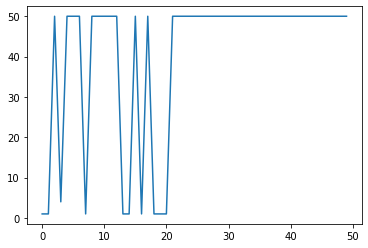

In [65]:
def initqTable(size, actions=[UP, DOWN, LEFT, RIGHT]):
    d = {}
    for i in range(size[0]):
        for j in range(size[1]):
            d[i,j] = np.zeros(len(actions))
    return d

# initGridWorld
gridWorld = GridWorld(gridSize, catP=catP, mouseP=mouseP)
# init q Table
qt = initqTable(gridSize)
# init q Circuit
qNet = QNet(qt, gridWorld, gamma=gamma)
# init cat
cat = Cat(qNet=qNet)
# init pet school
petSchool = PetSchool(cat, EPS, MAX_EPS_STEP)
# start training
petSchool.train()

m emp emp 
emp emp c 
emp emp emp 

qTable:  {(0, 0): array([0., 0., 0., 0.]), (0, 1): array([ 979.  ,  958.42, 1000.  ,    0.  ]), (0, 2): array([0., 0., 0., 0.]), (1, 0): array([1000.        ,    0.        ,  979.        ,  958.41999466]), (1, 1): array([978.999999, 938.2516  , 979.      , 938.2516  ]), (1, 2): array([  0.    ,   0.    , 958.42  , 938.2516]), (2, 0): array([979.    , 958.42  , 958.42  , 938.2516]), (2, 1): array([958.42  , 938.2516,   0.    ,   0.    ]), (2, 2): array([938.2516  , 918.486568, 938.2516  , 918.486568])}

params:  {(0, 0): (array([0.77132064, 0.02075195, 0.63364823, 0.74880388, 0.49850701,
       0.22479665]), 0.0, 0), (0, 1): (array([1.19814909, 1.88572543, 1.16915678, 0.08833226, 1.68546292,
       1.07834858]), 0.0, 53), (0, 2): (array([0.00394827, 0.51219226, 0.81262096, 0.61252607, 0.72175532,
       0.29187607]), 0.0, 0), (1, 0): (array([2.91777412, 0.71457578, 0.54264437, 0.14207005, 0.37334076,
       0.67403362]), -1.0, 41), (1, 1): (array([7.4

C:\Users\sun\AppData\Local\Temp/ipykernel_32288/861926727.py:119: RuntimeWarning: invalid value encountered in double_scalars
  vecx[i,j]=-vecx[i,j]/norm
C:\Users\sun\AppData\Local\Temp/ipykernel_32288/861926727.py:120: RuntimeWarning: invalid value encountered in double_scalars
  vecy[i,j]=-vecy[i,j]/norm


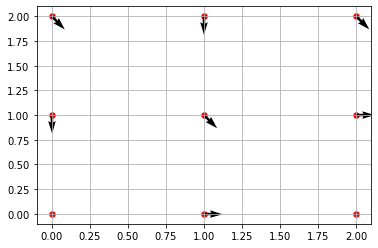

In [66]:
# show what have been learned
petSchool.show()

In [68]:
# @Vasily Bokov
backend = Aer.get_backend("qasm_simulator")
NUM_SHOTS = 1000 # number of measurements 
optimizer = COBYLA(maxiter=500, tol=0.0001) # off the shelf


def qcMaker(params):
    qr = QuantumRegister(2, name="q")
    cr = ClassicalRegister(2, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u3(params[0], params[1], params[2], qr[0])
    qc.u3(params[3], params[4], params[5], qr[1])
    qc.measure(qr, cr)
    return qc

def calcActions(d):
 
    actions = dict()
    for key in d.keys():
        qc = qcMaker(d[key][0])
        t_qc = transpile(qc, backend)
        job = assemble(t_qc, shots=NUM_SHOTS)
        rlt = backend.run(job).result()
        counts = rlt.get_counts(qc) 
        action = max(counts, key = counts.get)
        actions[key] = action
        
    return actions

# qt is a dict with all q-values
def calcPerformance(d, actions: dict, qt: dict):
    diff = 0
    # the difference between two action is defined as the steps difference between two action
    # e.g. left needs two steps turn to right.
    def difference(a, b):
        if a == UP:
            if b == DOWN:
                return 2*2/5
            else:
                return 1/5
        elif a == DOWN:
            if b == UP:
                return 2*2/5
            else:
                return 1/5
        elif a == LEFT:
            if b == RIGHT:
                return 2*2/5
            else:
                return 1/5
        elif a == RIGHT:
            if b == LEFT:
                return 2*2/5
            else:
                return 1/5

    for key in d.keys():
        action = ACTIONS[int(actions[key],2)] # "00","01"
        targetAction = ACTIONS[np.argmax(qt[key])] # "00","01"
        if action != targetAction:
            diff += difference(action, targetAction)
    return diff/len(d.keys())

qt, rets = petSchool.result()
    
print("MSE of trained circuit: ", calcPerformance(rets, calcActions(rets), qt))

MSE of trained circuit:  -0.7333333333333334
